# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split

# Load the dataset

In [2]:
# Load dataset (local)
# dataset_zip = np.load('../dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='bytes')

# Load dataset (Kaggle)
dataset_zip = np.load('/kaggle/input/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='bytes')

In [26]:
# create a class dSpritesDataset -> DataLoader
class dSpritesDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        return img
    
class RescaleBinaryImage:
    def __call__(self, tensor):
        return tensor / tensor.max()

transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleBinaryImage()
])

imgs = dataset_zip['imgs']
dsprites = dSpritesDataset(imgs, transform=transform)

subset_size = 15000
dsprites_small = random_split(dsprites, [subset_size, len(imgs)-subset_size])[0]
imgs_train, imgs_test = random_split(dsprites_small, [0.8, 0.2])

batch_size = 64
imgs_trainloader = DataLoader(imgs_train, batch_size=batch_size, shuffle=True)
imgs_testloader = DataLoader(imgs_test, batch_size=batch_size, shuffle=True)

# Some visualizations

In [28]:
img = next(iter(imgs_trainloader))
img.shape

torch.Size([64, 1, 64, 64])

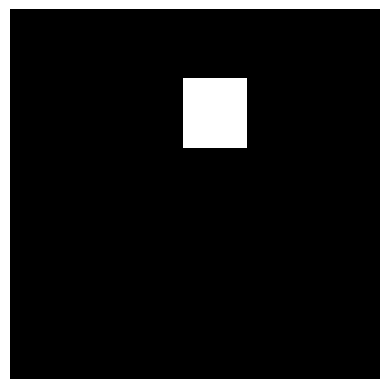

In [43]:
# view images from dataloader

plt.imshow(img[0].permute(1,2,0), cmap='gray', vmin=img[0].min().item(), vmax=img[0].max().item())
plt.axis('off')
plt.show()

# The Beta-VAE architecture

In [77]:
class Encoder(nn.Module):
    def __init__(self, input_dim=64, z_dim=10, h_dim1=32, h_dim2=64, fc_dim=128, n_channels=1, kernel_size=4, stride=2):
        super(Encoder, self).__init__()

        self.input_dim = input_dim
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.h_dim1 = h_dim1
        self.h_dim2 = h_dim2
        self.z_dim = z_dim
        self.fc_dim = fc_dim
        
        self.output_size = 2

        self.conv1 = nn.Conv2d(self.n_channels, self.h_dim1, kernel_size=self.kernel_size, stride=self.stride)
        self.conv2 = nn.Conv2d(self.h_dim1, self.h_dim1, kernel_size=self.kernel_size, stride=self.stride)
        self.conv3 = nn.Conv2d(self.h_dim1, self.h_dim2, kernel_size=self.kernel_size, stride=self.stride)
        self.conv4 = nn.Conv2d(self.h_dim2, self.h_dim2, kernel_size=self.kernel_size, stride=self.stride)
        
        self.fc = nn.Linear(self.output_size * self.output_size * self.h_dim2, self.fc_dim)
        self.fc_mu = nn.Linear(self.fc_dim, self.z_dim)
        self.fc_logvar = nn.Linear(self.fc_dim, self.z_dim)

    def forward(self, x):
        out = F.relu(self.conv1(x))  # [64, 32, 31, 31]
        out = F.relu(self.conv2(out)) # [64, 32, 14, 14]
        out = F.relu(self.conv3(out)) # [64, 64, 6, 6]
        out = F.relu(self.conv4(out)) # [64, 64, 2, 2]
        
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, input_dim=64, z_dim=10, h_dim=32, h_dim2=64, fc_dim=128, n_channels=1, kernel_size=4, stride=2):
        super(Decoder, self).__init__()

        self.input_dim = input_dim
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.h_dim = h_dim
        self.h_dim2 = h_dim2
        self.z_dim = z_dim
        self.fc_dim = fc_dim

        self.fc1 = nn.Linear(self.z_dim, self.fc_dim)   # [64, 128]
        self.fc2 = nn.Linear(self.fc_dim, self.kernel_size * self.kernel_size * self.h_dim2)   # [64, 4 x 4 x 64] -> [64, 64, 4, 4]
        
        self.conv1 = nn.ConvTranspose2d(self.h_dim2, self.h_dim2, kernel_size=kernel_size, stride=stride, padding=1)    # [64, 64, 8, 8]
        self.conv2 = nn.ConvTranspose2d(self.h_dim2, self.h_dim, kernel_size=kernel_size, stride=stride, padding=1)     # [64, 32, 16, 16]
        self.conv3 = nn.ConvTranspose2d(self.h_dim, self.h_dim, kernel_size=kernel_size, stride=stride, padding=1)      # [64, 32, 32, 32]
        self.conv4 = nn.ConvTranspose2d(self.h_dim, self.n_channels, kernel_size=kernel_size, stride=stride, padding=1) # [64, 1, 64, 64]

    def forward(self, z):
        out = F.relu(self.fc1(z))
        out = F.relu(self.fc2(out))
        out = out.reshape(out.shape[0], self.h_dim2, self.kernel_size, self.kernel_size)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        y = torch.sigmoid(self.conv4(out))  # to ensure the image has values between 0 and 1
        return y


class BetaVAE(nn.Module):
    def __init__(self, beta):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.beta = beta

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

    def loss_function(self, x_recon, x, mu, log_var):
        BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')  # the output has sigmoid, so we use basic BCE
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + self.beta * KLD

# The training pipeline

In [78]:
# Hyperparameters
beta = 1
learning_rate = 1e-3

# training phase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetaVAE(beta).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

epochs = 100

for epoch in range(epochs):
    print(f"========================EPOCH n°{epoch+1}========================")
    model.train()
    train_loss = 0
    for i, data in enumerate(imgs_trainloader):
        optimizer.zero_grad()
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch+1, train_loss / len(imgs_trainloader.dataset)))

========================EPOCH n°1========================
====> Epoch: 1 Average loss: 703.8753
========================EPOCH n°2========================
====> Epoch: 2 Average loss: 220.0257
========================EPOCH n°3========================
====> Epoch: 3 Average loss: 135.6607
========================EPOCH n°4========================
====> Epoch: 4 Average loss: 125.2225
========================EPOCH n°5========================
====> Epoch: 5 Average loss: 118.0510
========================EPOCH n°6========================
====> Epoch: 6 Average loss: 110.3559
========================EPOCH n°7========================
====> Epoch: 7 Average loss: 104.4362
========================EPOCH n°8========================
====> Epoch: 8 Average loss: 101.5896
========================EPOCH n°9========================
====> Epoch: 9 Average loss: 99.9165
========================EPOCH n°10========================
====> Epoch: 10 Average loss: 98.0877
========================EPOCH n°11======

KeyboardInterrupt: 

# Save/Load model (if needed)

In [79]:
# Save the model if needed
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'betaVAE_{}_epochs.pt'.format(epoch))

In [ ]:
# #Load the model if needed
# model = BetaVAE(beta).to(device)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# checkpoint = torch.load('betaVAE_{}_epochs.pt'.format(epoch))
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']

# Compare the reconstructions with the original data

In [80]:
def plot_reconstructions(model, data_loader, device, n=10):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            data = data.cpu()
            recon_batch = recon_batch.cpu()
            for i in range(n):
                plt.subplot(2, n, i + 1)
                plt.imshow(data[i].permute(1,2,0), cmap='gray')
                plt.axis('off')
                plt.subplot(2, n, i + 1 + n)
                plt.imshow(recon_batch[i].permute(1,2,0), cmap='gray')
                plt.axis('off')
            plt.show()

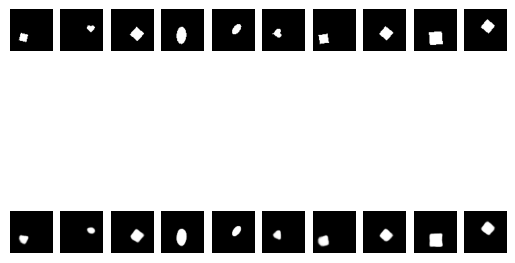

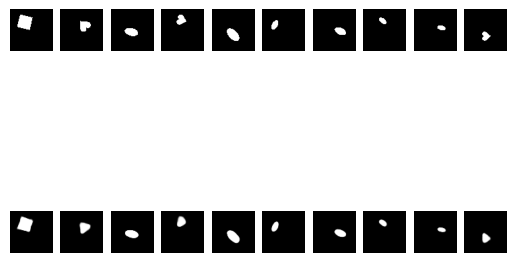

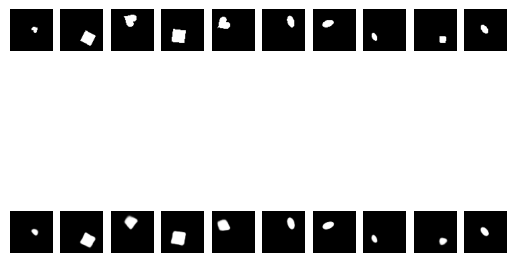

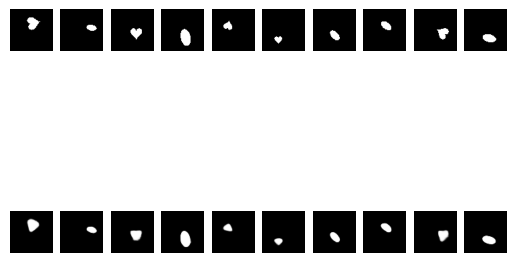

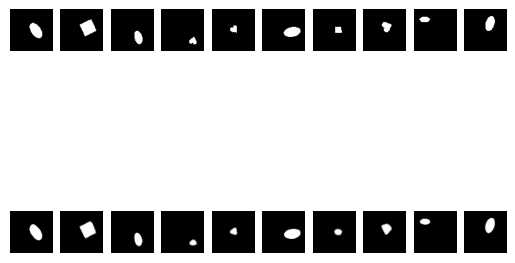

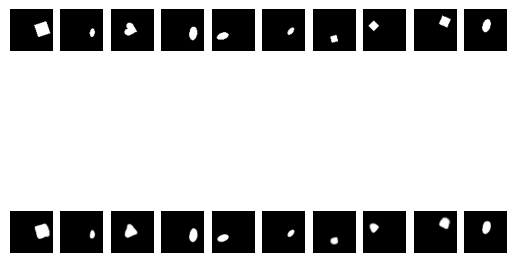

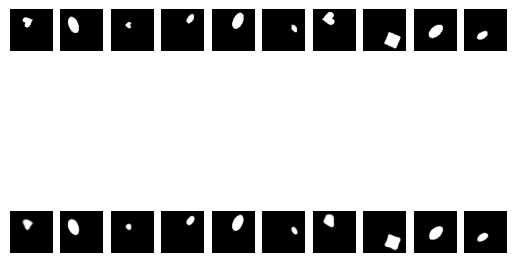

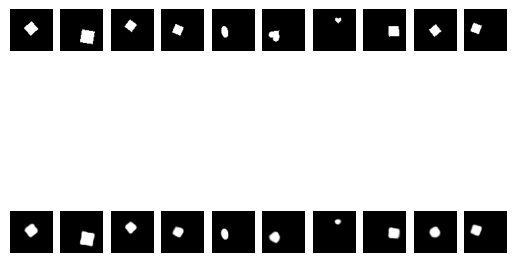

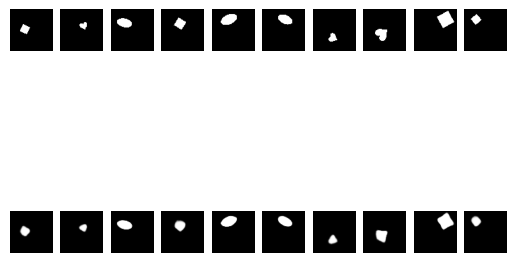

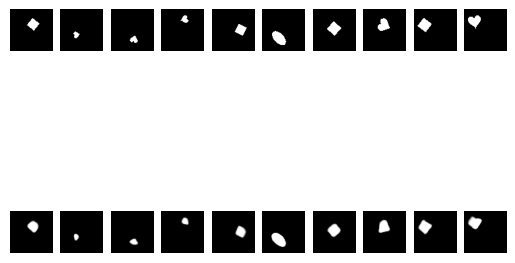

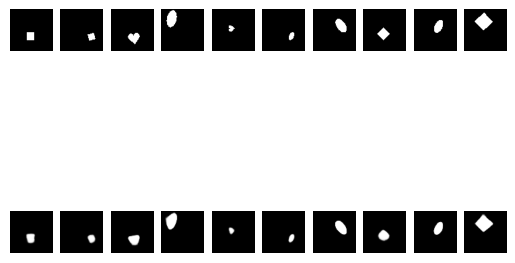

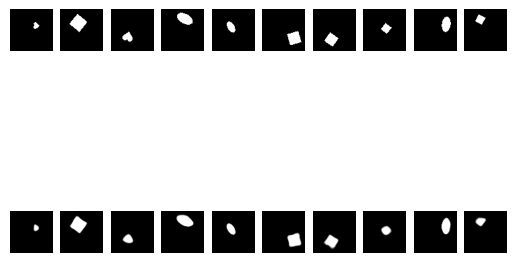

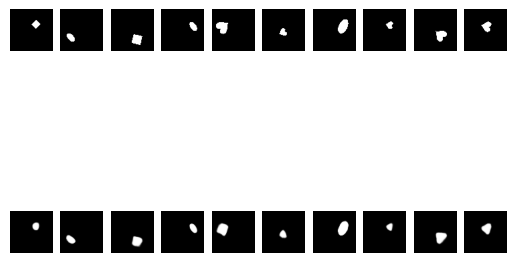

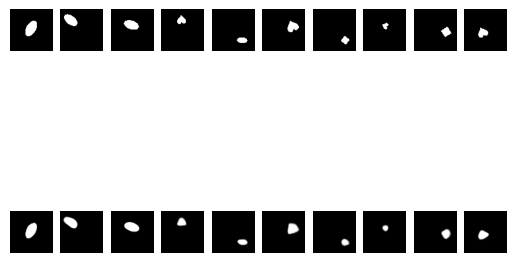

KeyboardInterrupt: 

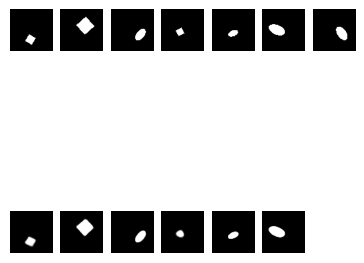

In [82]:
plot_reconstructions(model, imgs_testloader, device)

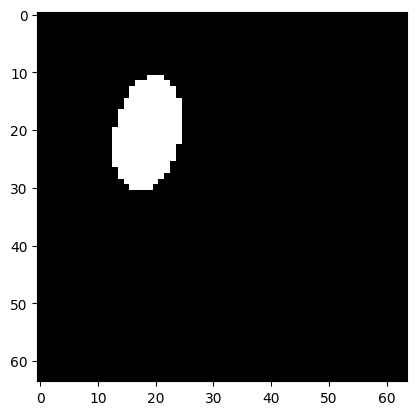

In [83]:
plt.imshow(data[0].squeeze().cpu().detach().numpy(), cmap='Greys_r')

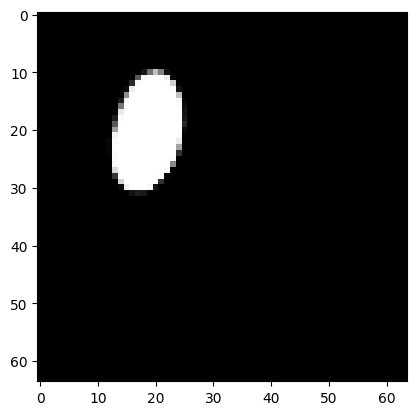

In [84]:
plt.imshow(recon_batch[0].squeeze().cpu().detach().numpy(), cmap='Greys_r')